# Team: Hari Kiran Pendurthi & Srija Kandula

In [3]:
#Installing MuJoCo.
#!pip install mujoco

#print('MuJoCo installation successful.')

#Installing mediapy for media manipulation
#!pip install -q mediapy

import mediapy as media
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Rectangle
import time

Checking that the installation succeeded:
MuJoCo installation successful.
Installing mediapy:


In [93]:
#target tracking Humanoid XML
xml = """
<mujoco model="CustomHumanoid">
  <option timestep="0.005"/>

  <visual>
    <map force="0.2" zfar="30"/>
    <rgba haze="0.1 0.3 0.5 1"/>
    <global offwidth="1920" offheight="1080" elevation="-30" azimuth="150"/>
  </visual>

  <statistic center="0 0 0.8"/>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".2 .4 .6" rgb2="0 0 0" width="64" height="1024"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="1 1 1" rgb2="1 1 1" markrgb="1 1 1" random="0.05"/>
    <material name="body" texture="body" texuniform="true" rgba="1 1 1 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".2 .3 .4" rgb2=".3 .4 .5"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".3"/>
  </asset>

  <default>
    <position inheritrange="0.9"/>
    <default class="body">
      <!-- geoms -->
      <geom type="capsule" condim="1" friction=".6" solimp="0.8 .95 .001" solref=".02 1" material="body" group="1"/>
      <default class="thigh">
        <geom size=".05"/>
      </default>
      <default class="shin">
        <geom fromto="0 0 0 0 0 -.3"  size=".049"/>
      </default>
      <default class="foot">
        <geom size=".027"/>
        <default class="foot1">
          <geom fromto="-.07 -.01 0 .14 -.03 0"/>
        </default>
        <default class="foot2">
          <geom fromto="-.07 .01 0 .14  .03 0"/>
        </default>
      </default>
      <default class="arm_upper">
        <geom size=".04"/>
      </default>
      <default class="arm_lower">
        <geom size=".031"/>
      </default>
      <default class="hand">
        <geom type="sphere" size=".04"/>
      </default>
    </default>
    <default class="joint">
      <joint type="hinge" damping=".2" stiffness="1" armature=".01" limited="true" solimplimit="0 .99 .01"/>
      <default class="joint_big">
        <joint damping="5" stiffness="10"/>
        <default class="hip_x">
          <joint range="-30 10"/>
        </default>
        <default class="hip_z">
          <joint range="-60 35"/>
        </default>
        <default class="hip_y">
          <joint axis="0 1 0" range="-150 20"/>
        </default>
      </default>
      <default class="knee">
        <joint pos="0 0 .02" axis="0 -1 0" range="-160 2"/>
      </default>
      <default class="ankle">
        <joint range="-50 50"/>
        <default class="ankle_y">
          <joint pos="0 0 .08" axis="0 1 0" stiffness="6"/>
        </default>
        <default class="ankle_x">
          <joint pos="0 0 .04" stiffness="3"/>
        </default>
      </default>
      <default class="shoulder">
        <joint range="-85 60"/>
      </default>
      <default class="elbow">
        <joint range="-100 50" stiffness="0"/>
      </default>
    </default>
  </default>

  <worldbody>
    <body name="target" pos=".2 -.2 1" mocap="true">
      <site name="target" size=".05" rgba="1 0 1 .4"/>
    </body>
    <geom name="floor" size="0 0 .05" type="plane" material="grid" condim="3"/>
    <light name="spotlight" mode="targetbodycom" target="torso" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="torso" pos="0 0 1.282" childclass="body">
      <light name="top" pos="0 0 2" mode="trackcom"/>
      <camera name="back" pos="-3 0 1" xyaxes="0 -1 0 1 0 2" mode="trackcom"/>
      <camera name="side" pos="0 -3 1" xyaxes="1 0 0 0 1 2" mode="trackcom"/>
      <freejoint name="root"/>
      <geom name="torso" fromto="0 -.07 0 0 .07 0" size=".07"/>
      <geom name="waist_upper" fromto="-.01 -.06 -.12 -.01 .06 -.12" size=".06"/>
      <body name="head" pos="0 0 .19">
        <geom name="head" type="sphere" size=".09"/>
        <camera name="egocentric" pos=".09 0 0" xyaxes="0 -1 0 .1 0 1" fovy="80"/>
      </body>
      <body name="waist_lower" pos="-.01 0 -.26">
        <geom name="waist_lower" fromto="0 -.06 0 0 .06 0" size=".06"/>
        <joint name="abdomen_z" pos="0 0 .065" axis="0 0 1" range="-45 45" class="joint_big"/>
        <joint name="abdomen_y" pos="0 0 .065" axis="0 1 0" range="-75 30" class="joint_big"/>
        <body name="pelvis" pos="0 0 -.165">
          <joint name="abdomen_x" pos="0 0 .1" axis="1 0 0" range="-35 35" class="joint_big"/>
          <geom name="butt" fromto="-.02 -.07 0 -.02 .07 0" size=".09"/>
          <body name="thigh_right" pos="0 -.1 -.04">
            <joint name="hip_x_right" axis="1 0 0" class="hip_x"/>
            <joint name="hip_z_right" axis="0 0 1" class="hip_z"/>
            <joint name="hip_y_right" class="hip_y"/>
            <geom name="thigh_right" fromto="0 0 0 0 .01 -.34" class="thigh"/>
            <body name="shin_right" pos="0 .01 -.4">
              <joint name="knee_right" class="knee"/>
              <geom name="shin_right" class="shin"/>
              <body name="foot_right" pos="0 0 -.39">
                <joint name="ankle_y_right" class="ankle_y"/>
                <joint name="ankle_x_right" class="ankle_x" axis="1 0 .5"/>
                <geom name="foot1_right" class="foot1"/>
                <geom name="foot2_right" class="foot2"/>
              </body>
            </body>
          </body>
          <body name="thigh_left" pos="0 .1 -.04">
            <joint name="hip_x_left" axis="-1 0 0" class="hip_x"/>
            <joint name="hip_z_left" axis="0 0 -1" class="hip_z"/>
            <joint name="hip_y_left" class="hip_y"/>
            <geom name="thigh_left" fromto="0 0 0 0 -.01 -.34" class="thigh"/>
            <body name="shin_left" pos="0 -.01 -.4">
              <joint name="knee_left" class="knee"/>
              <geom name="shin_left" fromto="0 0 0 0 0 -.3" class="shin"/>
              <body name="foot_left" pos="0 0 -.39">
                <joint name="ankle_y_left" class="ankle_y"/>
                <joint name="ankle_x_left" class="ankle_x" axis="-1 0 -.5"/>
                <geom name="foot1_left" class="foot1"/>
                <geom name="foot2_left" class="foot2"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <body name="upper_arm_right" pos="0 -.17 .06">
        <joint name="shoulder1_right" axis="2 1 1"  class="shoulder"/>
        <joint name="shoulder2_right" axis="0 -1 1" class="shoulder"/>
        <geom name="upper_arm_right" fromto="0 0 0 .16 -.16 -.16" class="arm_upper"/>
        <body name="lower_arm_right" pos=".18 -.18 -.18">
          <joint name="elbow_right" axis="0 -1 1" class="elbow"/>
          <geom name="lower_arm_right" fromto=".01 .01 .01 .17 .17 .17" class="arm_lower"/>
          <body name="hand_right" pos=".18 .18 .18">
            <geom name="hand_right" zaxis="1 1 1" class="hand" rgba="1 1 1 1"/>
          </body>
        </body>
      </body>
      <body name="upper_arm_left" pos="0 .17 .06">
        <joint name="shoulder1_left" axis="-2 1 -1" class="shoulder"/>
        <joint name="shoulder2_left" axis="0 -1 -1"  class="shoulder"/>
        <geom name="upper_arm_left" fromto="0 0 0 .16 .16 -.16" class="arm_upper"/>
        <body name="lower_arm_left" pos=".18 .18 -.18">
          <joint name="elbow_left" axis="0 -1 -1" class="elbow"/>
          <geom name="lower_arm_left" fromto=".01 -.01 .01 .17 -.17 .17" class="arm_lower"/>
          <body name="hand_left" pos=".18 -.18 .18">
            <geom name="hand_left" zaxis="1 -1 1" class="hand"/>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <contact>
    <exclude body1="waist_lower" body2="thigh_right"/>
    <exclude body1="waist_lower" body2="thigh_left"/>
  </contact>

  <tendon>
    <fixed name="hamstring_right" limited="true" range="-0.3 2">
      <joint joint="hip_y_right" coef=".5"/>
      <joint joint="knee_right" coef="-.5"/>
    </fixed>
    <fixed name="hamstring_left" limited="true" range="-0.3 2">
      <joint joint="hip_y_left" coef=".5"/>
      <joint joint="knee_left" coef="-.5"/>
    </fixed>
  </tendon>

  <actuator>
    <position name="abdomen_z"       kp="40"  joint="abdomen_z"/>
    <position name="abdomen_y"       kp="40"  joint="abdomen_y"/>
    <position name="abdomen_x"       kp="40"  joint="abdomen_x"/>
    <position name="hip_x_right"     kp="40"  joint="hip_x_right"/>
    <position name="hip_z_right"     kp="40"  joint="hip_z_right"/>
    <position name="hip_y_right"     kp="120" joint="hip_y_right"/>
    <position name="knee_right"      kp="80"  joint="knee_right"/>
    <position name="ankle_y_right"   kp="20"  joint="ankle_y_right"/>
    <position name="ankle_x_right"   kp="20"  joint="ankle_x_right"/>
    <position name="hip_x_left"      kp="40"  joint="hip_x_left"/>
    <position name="hip_z_left"      kp="40"  joint="hip_z_left"/>
    <position name="hip_y_left"      kp="120" joint="hip_y_left"/>
    <position name="knee_left"       kp="80"  joint="knee_left"/>
    <position name="ankle_y_left"    kp="20"  joint="ankle_y_left"/>
    <position name="ankle_x_left"    kp="20"  joint="ankle_x_left"/>
    <position name="shoulder1_right" kp="20"  joint="shoulder1_right"/>
    <position name="shoulder2_right" kp="20"  joint="shoulder2_right"/>
    <position name="elbow_right"     kp="40"  joint="elbow_right"/>
    <position name="shoulder1_left"  kp="20"  joint="shoulder1_left"/>
    <position name="shoulder2_left"  kp="20"  joint="shoulder2_left"/>
    <position name="elbow_left"      kp="40"  joint="elbow_left"/>
  </actuator>

  <keyframe>
    <!--
    The values below are split into rows for readibility:
      torso position
      torso orientation
      spinal
      right leg
      left leg
      arms
    -->
    <key name="squat"
         qpos="0 0 0.596
               0.988015 0 0.154359 0
               0 0.4 0
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               -0.25 -0.5 -2.5 -2.65 -0.8 0.56
               0 0 0 0 0 0"/>
    <key name="stand_on_left_leg"
         qpos="0 0 1.21948
               0.971588 -0.179973 0.135318 -0.0729076
               -0.0516 -0.202 0.23
               -0.24 -0.007 -0.34 -1.76 -0.466 -0.0415
               -0.08 -0.01 -0.37 -0.685 -0.35 -0.09
               0.109 -0.067 -0.7 -0.05 0.12 0.16"/>
    <key name="prone"
         qpos="0.4 0 0.0757706
               0.7325 0 0.680767 0
               0 0.0729 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.0077 0.0019 -0.026 -0.351 -0.27 0
               0.56 -0.62 -1.752
               0.56 -0.62 -1.752"/>
    <key name="supine"
         qpos="-0.4 0 0.08122
               0.722788 0 -0.69107 0
               0 -0.25 0
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.0182 0.0142 0.3 0.042 -0.44 -0.02
               0.186 -0.73 -1.73
               0.186 -0.73 -1.73"/>
  </keyframe>
</mujoco>


"""

""

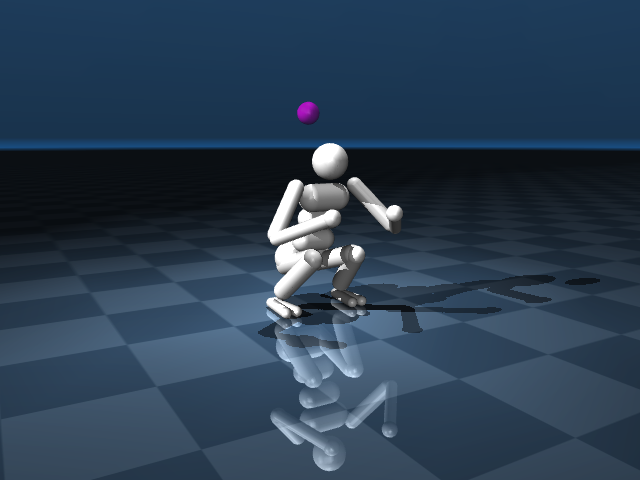

In [94]:
#Loading model
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)  

#Setting the state to the "squat" keyframe
key = model.key('squat').id
mujoco.mj_resetDataKeyframe(model, data, key)
mujoco.mj_forward(model, data)

#CLosing a renderer, if exists
if 'renderer' in locals():
  renderer.close()

#Making a Renderer and a camera
renderer = mujoco.Renderer(model, height=480, width=640)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 3
camera.elevation = -10

#Camera at the humanoid, render
camera.lookat = data.body('torso').subtree_com
renderer.update_scene(data, camera)
media.show_image(renderer.render())

In [95]:
#Reach func.
def reach(ctrl0T, target, T, torque_scale, traj=None):
  key = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_KEY, 'squat')
  mujoco.mj_resetDataKeyframe(model, data, key)

  #Visualization
  mocapid = model.body('target').mocapid
  data.mocap_pos[mocapid] = target

  #Extracting first and last ctrl vectors
  ctrl0 = ctrl0T[:model.nu]
  ctrlT = ctrl0T[model.nu:]

  #Rolling out 
  res = []
  while data.time < T:
    #Ctrl from ctrl0 and ctrlT.
    f0 = (T - data.time) / T
    f1 = 1 - f0
    data.ctrl = f0*ctrl0 + f1*ctrlT
    mujoco.mj_step(model, data)  

    #Appending hand to target 
    res.append(data.geom('hand_right').xpos - np.array(target))

    #Appending actuator torques
    res.append(torque_scale * data.actuator_force.flatten())

    #Save state to traj
    if traj is not None:
      traj.append(data.qpos.copy())

  #Normalizer 
  normalizer = 100 * model.opt.timestep / T
  return np.hstack(res).flatten() * normalizer

In [96]:
T = 0.7               #Rollout length (seconds)
torque_scale = 0.003  #Scaling for the torques

#Bounds
lower = model.actuator_ctrlrange[:,0]
upper = model.actuator_ctrlrange[:,1]
bounds = [np.hstack((lower, lower)), np.hstack((upper, upper))]

#Initial guess = midpoint of the bounds
x0 = 0.5 * (bounds[1] + bounds[0])

Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

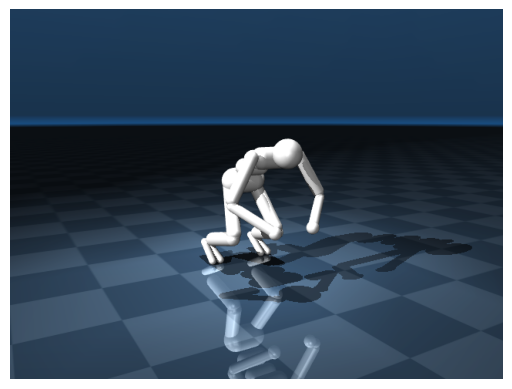

In [97]:
#render solution func.
def render_solution(x, target):
    traj = []
    reach(x, target, T, torque_scale, traj=traj)    
    counter = 0
    frames = []
    
    print('Rendering frames:', flush=True, end='')
    
    for qpos in traj:
        #Update kinematics.
        data.qpos = qpos
        mujoco.mj_forward(model, data)

        #Render and display frames.
        camera.lookat = data.body('torso').subtree_com
        renderer.update_scene(data, camera)
        pixels = renderer.render()
        
        #Save the frame
        frames.append(pixels)
        
        counter += 1
        if counter % 10 == 0:
            print(f' {counter}', flush=True, end='')
    
    return frames

#initial guess
target = (0., 0., -1.)  #(Under the floor target)
frames = render_solution(x0, target)

#Video from the frames
from matplotlib.animation import PillowWriter

#Updating the animation
def update(frame):
    im.set_array(frame)
    return im,

fig, ax = plt.subplots()
im = ax.imshow(frames[0], animated=True)
ax.axis('off')

ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
writer = PillowWriter(fps=10)
ani.save('rendered_video.gif', writer=writer)

#Display
HTML('<img src="rendered_video.gif">')


Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140

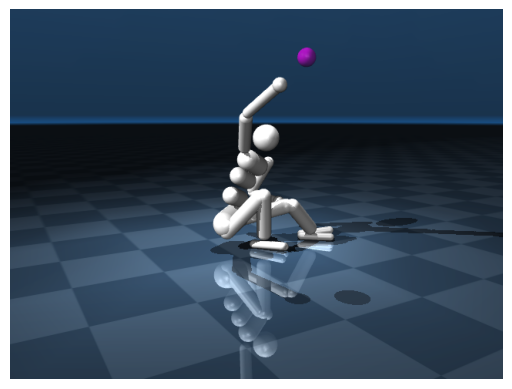

In [98]:
#Defining the target
target = (.4, -.3, 1.2)

reach_target = lambda x: reach(x, target, T, torque_scale, traj=None)

x0 = generate_initial_guess(bounds)

#Least Squares Minimization
result = minimize.least_squares(reach_target, x0, bounds=bounds)
x_optimal = result.x

#Rendering
frames = []
for i in range(10):  
    x = x0 + (x_optimal - x0) * i / 10  
    frames.append(render_solution(x, target)[-1])  

#Creating video from the frames
fig, ax = plt.subplots()
im = ax.imshow(frames[0], animated=True)
ax.axis('off')

def update(frame):
    im.set_array(frame)
    return im,

ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)
writer = PillowWriter(fps=10)
ani.save('optimization_video.gif', writer=writer)

#Video
HTML('<img src="optimization_video.gif">')


Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 80 90 100 110 120 130 140Rendering frames: 10 20 30 40 50 60 70 8

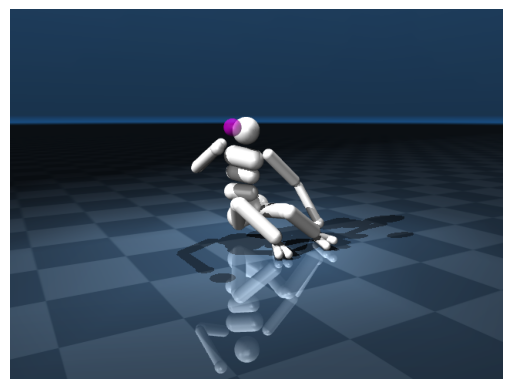

In [91]:
#target positions
targets = [
    (0.5, 0.5, 1.5),
    (-1.0, -1.0, 1.2),
    (-0.5, 0.3, 1.0),
    (0.0, -0.5, 0.8)
]

#reach_target function
def reach_target(x, target):
    return reach(x, target, T, torque_scale, traj=None)

#initial guess
x0 = generate_initial_guess(bounds)

#least squares
all_frames = []
for target in targets:
    result = minimize.least_squares(lambda x: reach_target(x, target), x0, bounds=bounds)
    x_optimal = result.x
    
    #Rendering frames 
    frames = []
    for i in range(10):  
        x = x0 + (x_optimal - x0) * i / 10  
        frames.append(render_solution(x, target)[-1]) 
    
    all_frames.extend(frames)

#Creating video from frames
fig, ax = plt.subplots()
im = ax.imshow(all_frames[0], animated=True)
ax.axis('off')

def update(frame):
    im.set_array(frame)
    return im,

ani = FuncAnimation(fig, update, frames=all_frames, interval=100, blit=True)
writer = PillowWriter(fps=10)
ani.save('multi_target_optimization_video.gif', writer=writer)

#Video
HTML('<img src="multi_target_optimization_video.gif">')
